<a href="https://colab.research.google.com/github/GreiceMTeixeira/anytime_sorting/blob/master/Corsort_vs_Multizip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparação: Corsort vs Multizip Sort
Este notebook compara os algoritmos **Corsort-Δρ** e **Multizip Sort** com base na métrica de Spearman's Footrule.
- O **Corsort** é um algoritmo anytime baseado na escolha dinâmica de comparações.
- O **Multizip Sort** é uma variação do mergesort com interleaving de merges para melhor estimativa intermediária.


In [ ]:
# Imports
import numpy as np
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import math
import time
import random


## Função de distância de Spearman Footrule

In [ ]:
def spearman_footrule(estimate, true_sorted):
    n = len(estimate)
    rank_estimate = rankdata(estimate, method='ordinal')
    rank_true = rankdata(true_sorted, method='ordinal')
    return sum(abs(rank_estimate[i] - rank_true[i]) for i in range(n))

## Implementação do Corsort

In [ ]:
def corsort(X, max_comparisons=None):
    X = list(X)
    n = len(X)
    M = np.zeros((n, n), dtype=int)
    comparisons = []
    estimates = []

    def update_partial_order(i, j):
        nonlocal M
        for k in range(n):
            if M[k, i] == 1:
                for l in range(n):
                    if M[j, l] == 1:
                        M[k, l] = 1
                        M[l, k] = -1

    def compute_a_d_I_delta_rho():
        a = np.sum(M == 1, axis=1)
        d = np.sum(M == 1, axis=0)
        I = a + d
        delta = d - a
        with np.errstate(divide='ignore', invalid='ignore'):
            rho = d / (a + d)
            rho[np.isnan(rho)] = 0.5
        return a, d, I, delta, rho

    a, d, I, delta, rho = compute_a_d_I_delta_rho()

    while np.any(M == 0):
        incomparables = [(i, j) for i in range(n) for j in range(i+1, n)
                         if M[i, j] == 0 and M[j, i] == 0]

        if not incomparables or (max_comparisons and len(comparisons) >= max_comparisons):
            break

        best_pair = min(incomparables, key=lambda pair: (abs(delta[pair[0]] - delta[pair[1]]),
                                                         max(I[pair[0]], I[pair[1]])))
        i, j = best_pair

        if X[i] < X[j]:
            M[i, j] = 1
            M[j, i] = -1
        else:
            M[i, j] = -1
            M[j, i] = 1
            i, j = j, i

        comparisons.append((i, j))
        update_partial_order(i, j)

        a, d, I, delta, rho = compute_a_d_I_delta_rho()
        sorted_indices = sorted(range(n), key=lambda i: rho[i])
        estimate = [X[i] for i in sorted_indices]
        estimates.append(list(estimate))

    return estimates, comparisons

def corsort_batch(n_listas=5, tamanho=100, seed=42):
    np.random.seed(seed)
    tempos = []
    resultados = []

    print('--- Ordenando e comparando o tempo de cada lista ---\n')

    for i in range(n_listas):
        X = np.random.randint(0, 1000, tamanho)
        true_sorted = sorted(X)

        start = time.perf_counter()
        estimates, _ = corsort(X)
        end = time.perf_counter()

        final_estimate = estimates[-1] if estimates else list(X)
        tempo = end - start
        tempos.append(tempo)
        resultados.append((i + 1, final_estimate, tempo))

        print(f"Lista {i+1} ordenada:")
        for j in range(0, len(final_estimate), 30):
          print([int(x) for x in final_estimate[j:j+30]])
        print()

    print()
    for i, _, tempo in resultados:
        print(f"Tempo da Lista {i}: {tempo:.6f} segundos")

    mais_rapida = min(resultados, key=lambda x: x[2])
    print(f"\n**A lista que foi ordenada mais rapidamente é a Lista {mais_rapida[0]} com um tempo de {mais_rapida[2]:.6f} segundos.**")

corsort_batch()


--- Ordenando e comparando o tempo de cada lista ---

Lista 1 ordenada:
[1, 13, 20, 20, 21, 34, 58, 71, 80, 87, 91, 99, 102, 105, 106, 121, 130, 130, 160, 166, 189, 191, 205, 214, 241, 243, 252, 270, 273, 276]
[308, 313, 315, 330, 339, 343, 345, 366, 372, 385, 387, 387, 389, 401, 413, 427, 435, 454, 458, 459, 466, 474, 475, 476, 484, 491, 504, 508, 510, 560]
[561, 562, 564, 565, 566, 600, 614, 646, 661, 663, 681, 686, 699, 700, 702, 729, 747, 769, 771, 775, 776, 782, 805, 818, 821, 831, 840, 856, 860, 871]
[871, 875, 897, 931, 942, 955, 955, 957, 957, 975]

Lista 2 ordenada:
[4, 14, 14, 27, 32, 40, 40, 47, 52, 62, 64, 95, 98, 128, 134, 138, 156, 161, 187, 200, 201, 206, 216, 217, 230, 240, 251, 269, 270, 288]
[295, 337, 343, 378, 379, 391, 392, 397, 406, 418, 455, 460, 461, 461, 471, 489, 492, 498, 502, 502, 520, 546, 553, 555, 563, 573, 574, 592, 612, 642]
[647, 674, 683, 690, 701, 719, 724, 725, 726, 727, 738, 742, 748, 763, 766, 768, 772, 779, 791, 794, 804, 812, 815, 838, 839, 856,

## Implementação Multizip Sort

In [ ]:
def split(listas_y):
    novas_listas_z = []
    for y_list in listas_y:
        y_len = len(y_list)
        meio = math.ceil(y_len / 2)

        novas_listas_z.append(y_list[:meio])
        novas_listas_z.append(y_list[meio:])

    return novas_listas_z

def multizip_merge(listas_y):
    resultados_mesclados = []
    num_pares = len(listas_y) // 2
    for i in range(num_pares):
        lista1 = listas_y[i*2]
        lista2 = listas_y[i*2 + 1]

        merged_list = []
        ptr1, ptr2 = 0, 0

        while ptr1 < len(lista1) and ptr2 < len(lista2):
            if lista1[ptr1] <= lista2[ptr2]:
                merged_list.append(lista1[ptr1])
                ptr1 += 1
            else:
                merged_list.append(lista2[ptr2])
                ptr2 += 1

        merged_list.extend(lista1[ptr1:])
        merged_list.extend(lista2[ptr2:])

        resultados_mesclados.append(merged_list)

    if len(listas_y) % 2 != 0:
        resultados_mesclados.append(listas_y[-1])

    return resultados_mesclados

def multizip_sort(x):
    if not isinstance(x, list):
        raise TypeError("A entrada para multizip_sort deve ser uma lista.")

    y_lists = [x]

    ## Continua dividindo até que todas as sublistas tenham tamanho <= 1
    while any(len(lst) > 1 for lst in y_lists):
        y_lists = split(y_lists)

    ## Mescla as sublistas de volta até ter apenas uma lista ordenada
    while len(y_lists) > 1:
        y_lists = multizip_merge(y_lists)

    return y_lists[0]

todas_as_listas = []
for i in range(5):
    lista_aleatoria = [random.randint(0, 1000) for _ in range(100)]
    todas_as_listas.append(lista_aleatoria)

print("\n--- Ordenando e comparando o tempo de cada lista ---")
tempos_ordenacao = []
for i, lista in enumerate(todas_as_listas):

    start_time = time.perf_counter() # Marca o tempo de início
    lista_ordenada = multizip_sort(lista) # Chama sua função de ordenação
    end_time = time.perf_counter()   # Marca o tempo de fim
    tempo_gasto = end_time - start_time
    tempos_ordenacao.append(tempo_gasto)

    print(f"\nLista {i+1} ordenada: {lista_ordenada[:100]}...")

for i, tempo in enumerate(tempos_ordenacao):
    print(f"Tempo da Lista {i+1}: {tempo:.6f} segundos")

if tempos_ordenacao:
    min_time = min(tempos_ordenacao)
    min_index = tempos_ordenacao.index(min_time)
    print(f"\n**A lista que foi ordenada mais rapidamente é a Lista {min_index + 1} com um tempo de {min_time:.6f} segundos.**")
else:
    print("Nenhuma lista foi processada para comparação de tempo.")



--- Ordenando e comparando o tempo de cada lista ---

Lista 1 ordenada: [11, 14, 27, 42, 43, 47, 65, 69, 70, 78, 80, 97, 101, 104, 112, 130, 140, 143, 157, 157, 159, 168, 186, 192, 198, 205, 245, 245, 254, 265, 274, 276, 280, 285, 293, 320, 322, 332, 335, 337, 361, 366, 375, 378, 379, 381, 391, 400, 416, 421, 425, 452, 480, 494, 497, 499, 500, 505, 506, 507, 507, 515, 528, 560, 566, 567, 569, 573, 584, 586, 595, 605, 611, 636, 643, 644, 655, 658, 705, 716, 741, 759, 762, 763, 766, 767, 776, 784, 789, 810, 846, 857, 911, 919, 929, 933, 948, 962, 993, 993]...

Lista 2 ordenada: [34, 37, 77, 79, 96, 100, 104, 124, 127, 130, 133, 138, 149, 159, 195, 207, 209, 218, 226, 229, 231, 232, 263, 278, 331, 347, 355, 364, 370, 384, 388, 405, 407, 444, 451, 464, 472, 474, 478, 485, 497, 498, 499, 529, 542, 563, 581, 581, 587, 587, 596, 597, 606, 606, 624, 630, 631, 641, 643, 649, 650, 658, 660, 701, 708, 712, 713, 727, 757, 765, 765, 783, 787, 793, 795, 808, 816, 823, 831, 831, 840, 845, 861, 871, 

## Comparação dos dois algoritmos

In [ ]:
todas_as_listas = []
for i in range(5):
    lista_aleatoria = [random.randint(0, 1000) for _ in range(100)]
    todas_as_listas.append(lista_aleatoria)

tempos_corsort = []
tempos_multizip = []

for i, lista in enumerate(todas_as_listas):
    # Corsort
    inicio = time.perf_counter()
    ordenada_corsort = corsort(lista)
    fim = time.perf_counter()
    tempo_corsort = fim - inicio
    tempos_corsort.append(tempo_corsort)

for i, lista in enumerate(todas_as_listas):
    # Multizip
    inicio = time.perf_counter()
    ordenada_multizip = multizip_sort(lista)
    fim = time.perf_counter()
    tempo_multizip = fim - inicio
    tempos_multizip.append(tempo_multizip)

print("--- Tempos por Lista ---")
for i in range(5):
    print(f"Lista {i+1}: Corsort = {tempos_corsort[i]:.6f} s | Multizip = {tempos_multizip[i]:.6f} s")


# Melhor geral
tempo_total_corsort = sum(tempos_corsort)
tempo_total_multizip = sum(tempos_multizip)
print("\n--- Comparação Final ---")
if tempo_total_corsort < tempo_total_multizip:
    print(f"**Corsort foi mais rápido no total: {tempo_total_corsort:.6f} s vs {tempo_total_multizip:.6f} s**")
else:
    print(f"**Multizip foi mais rápido no total: {tempo_total_multizip:.6f} s vs {tempo_total_corsort:.6f} s**")

--- Tempos por Lista ---
Lista 1: Corsort = 4.862685 s | Multizip = 0.000241 s
Lista 2: Corsort = 3.501737 s | Multizip = 0.000176 s
Lista 3: Corsort = 3.604588 s | Multizip = 0.000183 s
Lista 4: Corsort = 4.676213 s | Multizip = 0.000181 s
Lista 5: Corsort = 3.575569 s | Multizip = 0.000168 s

--- Comparação Final ---
**Multizip foi mais rápido no total: 0.000950 s vs 20.220792 s**


##Implementação do Corsort com interrupção

In [ ]:
def corsort_interruptible(X, max_comparisons):
    """
    Implementação do Corsort que pode ser interrompida após um número máximo de comparações.
    Retorna a melhor estimativa da lista ordenada até o ponto de interrupção.
    """
    start_time = time.perf_counter()  # Inicia a contagem do tempo

    X = list(X)
    n = len(X)
    M = np.zeros((n, n), dtype=int)
    comparisons = []
    estimates = []

    def update_partial_order(i, j):
        """Atualiza a matriz de ordem parcial com base em uma nova comparação."""
        for k in range(n):
            if M[k, i] == 1:
                for l in range(n):
                    if M[j, l] == 1:
                        M[k, l] = 1
                        M[l, k] = -1

    def compute_rho():
        """Calcula o valor rho para cada elemento, usado para estimar a ordem."""
        a = np.sum(M == 1, axis=1)
        d = np.sum(M == 1, axis=0)
        with np.errstate(divide='ignore', invalid='ignore'):
            rho = d / (a + d)
            rho[np.isnan(rho)] = 0.5
        return rho

    rho = compute_rho()

    interrupted = False
    while np.any(M == 0):
        incomparables = [(i, j) for i in range(n) for j in range(i+1, n)
                         if M[i, j] == 0 and M[j, i] == 0]

        if not incomparables:
            break # Nao ha mais comparacoes possiveis

        if len(comparisons) >= max_comparisons:
            interrupted = True
            print(f"--- Interrupção: Alcançado o limite de {max_comparacoes} comparações. ---")
            break

        a = np.sum(M == 1, axis=1)
        d = np.sum(M == 1, axis=0)
        delta = d - a
        I = a + d

        # Tratamento para evitar erros se houver apenas um par incomparavel
        if len(incomparables) == 1:
            best_pair = incomparables[0]
        else:
             # Prioriza pares com a menor diferenca absoluta em delta, depois o maior I
            best_pair = min(incomparables, key=lambda pair: (abs(delta[pair[0]] - delta[pair[1]]),
                                                             max(I[pair[0]], I[pair[1]])))
        i, j = best_pair

        # Realiza a comparação
        if X[i] > X[j]: # Compare X[i] and X[j] directly
            # If X[i] > X[j], swap indices so i refers to the smaller element
            i, j = j, i

        # Now i is the index of the smaller element and j is the index of the larger element
        M[i, j] = 1
        M[j, i] = -1

        comparisons.append((i, j))
        update_partial_order(i, j)
        rho = compute_rho()

        # Gera as estimativas - opcionalmente pode gerar a cada k comparacoes para performance
        sorted_indices = sorted(range(n), key=lambda i: rho[i])
        estimate = [X[i] for i in sorted_indices]
        estimates.append(estimate)

    end_time = time.perf_counter() # Finaliza a contagem do tempo
    print(f"--- Tempo de execução: {end_time - start_time:.6f} segundos. ---")

    return estimates[-1] if estimates else list(X)

## Implementação do Multizip com interrupção

In [ ]:
def multizip_sort_interruptible(x, max_comparisons):
    if not isinstance(x, list):
        raise TypeError("A entrada para multizip_sort deve ser uma lista.")

    start_time = time.perf_counter() # Inicia a contagem do tempo

    comparison_counter = [0]  # encapsulado em lista para ser mutável
    y_lists = [x]

    def merge_interrupt(lista1, lista2):
        result = []
        ptr1 = ptr2 = 0
        while ptr1 < len(lista1) and ptr2 < len(lista2):
            if comparison_counter[0] >= max_comparisons:
                # Interrompe a fusao atual se o limite for atingido
                break
            comparison_counter[0] += 1
            if lista1[ptr1] <= lista2[ptr2]:
                result.append(lista1[ptr1])
                ptr1 += 1
            else:
                result.append(lista2[ptr2])
                ptr2 += 1
        result.extend(lista1[ptr1:])
        result.extend(lista2[ptr2:])
        return result

    # Split até ter listas de tamanho 1
    while any(len(lst) > 1 for lst in y_lists):
        novas = []
        for y in y_lists:
            meio = math.ceil(len(y) / 2)
            novas.append(y[:meio])
            novas.append(y[meio:])
        y_lists = novas

    # Merge com interrupção
    interrupted_merge = False
    while len(y_lists) > 1:
        nova_y = []
        i = 0
        while i + 1 < len(y_lists):
            # Passa o contador de comparacoes para a funcao merge
            merged = merge_interrupt(y_lists[i], y_lists[i + 1])
            nova_y.append(merged)
            i += 2
            if comparison_counter[0] >= max_comparisons:
                interrupted_merge = True
                print(f"--- Interrupção na fusão: Alcançado o limite de {max_comparisons} comparações. ---")
                break # Interrompe o loop de fusao atual
        if i < len(y_lists) and not interrupted_merge:
            nova_y.append(y_lists[i])
        y_lists = nova_y

        if interrupted_merge:
            break # Interrompe o loop principal se a fusao foi interrompida


    end_time = time.perf_counter() # Finaliza a contagem do tempo
    print(f"--- Tempo de execução: {end_time - start_time:.6f} segundos. ---")

    # Junta tudo mesmo se incompleto
    resultado_final = []
    for sub in y_lists:
        resultado_final.extend(sub)

    return resultado_final

##Comparação

In [ ]:
lista = [random.randint(0, 1000) for _ in range(100)]

print("Estimativa com Corsort (interrompido em 50 comparações):")
print(corsort_interruptible(lista, 50)[:20])

print("\nEstimativa com Multizip (interrompido em 50 comparações):")
print(multizip_sort_interruptible(lista, 50)[:20])


Estimativa com Corsort (interrompido em 50 comparações):
--- Interrupção: Alcançado o limite de 75 comparações. ---
--- Tempo de execução: 0.382464 segundos. ---
[162, 147, 567, 82, 310, 263, 51, 390, 334, 223, 714, 418, 28, 80, 339, 193, 292, 389, 394, 147]

Estimativa com Multizip (interrompido em 50 comparações):
[147, 162, 216, 297, 209, 567, 758, 82, 310, 524, 51, 263, 657, 390, 482, 507, 334, 490, 954, 223]


##Gráfico comparativo

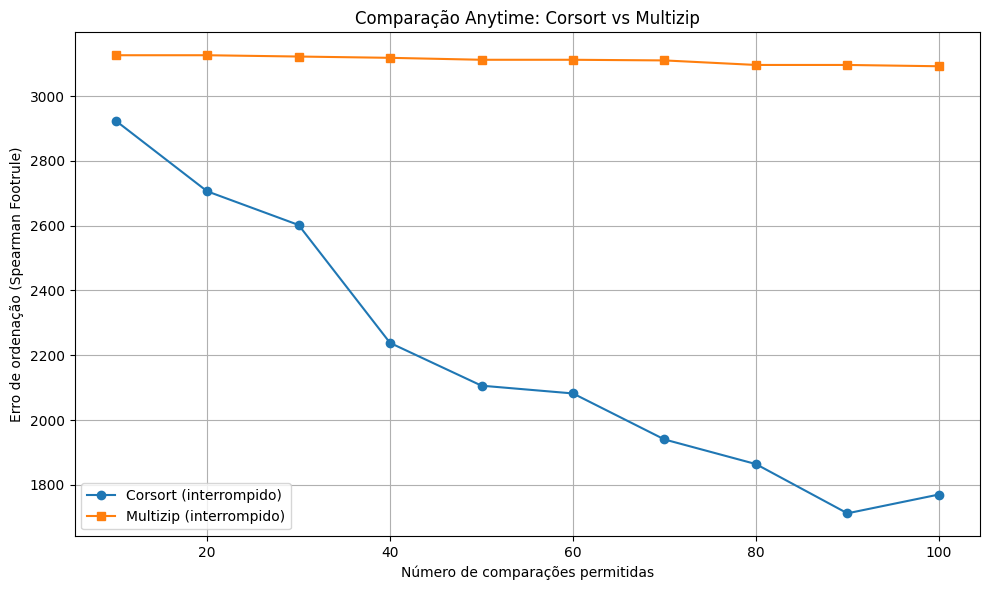

In [ ]:
import numpy as np
import math
import random
from scipy.stats import rankdata
import matplotlib.pyplot as plt

def spearman_footrule(estimate, true_sorted):
    rank_estimate = rankdata(estimate, method='ordinal')
    rank_true = rankdata(true_sorted, method='ordinal')
    return sum(abs(rank_estimate[i] - rank_true[i]) for i in range(len(estimate)))

def corsort_interruptible(X, max_comparisons):
    X = list(X)
    n = len(X)
    M = np.zeros((n, n), dtype=int)
    comparisons = []

    def update_partial_order(i, j):
        for k in range(n):
            if M[k, i] == 1:
                for l in range(n):
                    if M[j, l] == 1:
                        M[k, l] = 1
                        M[l, k] = -1

    def compute_rho():
        a = np.sum(M == 1, axis=1)
        d = np.sum(M == 1, axis=0)
        with np.errstate(divide='ignore', invalid='ignore'):
            rho = d / (a + d)
            rho[np.isnan(rho)] = 0.5
        return rho

    rho = compute_rho()

    while np.any(M == 0):
        incomparables = [(i, j) for i in range(n) for j in range(i+1, n)
                         if M[i, j] == 0 and M[j, i] == 0]
        if not incomparables or len(comparisons) >= max_comparisons:
            break

        a = np.sum(M == 1, axis=1)
        d = np.sum(M == 1, axis=0)
        delta = d - a
        I = a + d

        best_pair = min(incomparables, key=lambda pair: (abs(delta[pair[0]] - delta[pair[1]]),
                                                         max(I[pair[0]], I[pair[1]])))
        i, j = best_pair

        if X[i] < X[j]:
            M[i, j] = 1
            M[j, i] = -1
        else:
            M[i, j] = -1
            M[j, i] = 1
            i, j = j, i

        comparisons.append((i, j))
        update_partial_order(i, j)
        rho = compute_rho()

    sorted_indices = sorted(range(n), key=lambda i: rho[i])
    return [X[i] for i in sorted_indices]

def multizip_sort_interruptible(x, max_comparisons):
    comparison_counter = [0]
    y_lists = [x]

    def merge_interrupt(lista1, lista2):
        result = []
        ptr1 = ptr2 = 0
        while ptr1 < len(lista1) and ptr2 < len(lista2):
            if comparison_counter[0] >= max_comparisons:
                break
            comparison_counter[0] += 1
            if lista1[ptr1] <= lista2[ptr2]:
                result.append(lista1[ptr1])
                ptr1 += 1
            else:
                result.append(lista2[ptr2])
                ptr2 += 1
        result.extend(lista1[ptr1:])
        result.extend(lista2[ptr2:])
        return result

    while any(len(lst) > 1 for lst in y_lists):
        novas = []
        for y in y_lists:
            meio = math.ceil(len(y) / 2)
            novas.append(y[:meio])
            novas.append(y[meio:])
        y_lists = novas

    while len(y_lists) > 1:
        nova_y = []
        i = 0
        while i + 1 < len(y_lists):
            merged = merge_interrupt(y_lists[i], y_lists[i + 1])
            nova_y.append(merged)
            i += 2
        if i < len(y_lists):
            nova_y.append(y_lists[i])
        y_lists = nova_y
        if comparison_counter[0] >= max_comparisons:
            break

    resultado_final = []
    for sub in y_lists:
        resultado_final.extend(sub)
    return resultado_final

# Comparação visual
random.seed(42)
X = [random.randint(0, 1000) for _ in range(100)]
true_sorted = sorted(X)

ks = list(range(10, 101, 10))
errors_corsort = []
errors_multizip = []

for k in ks:
    est_corsort = corsort_interruptible(X, k)
    est_multizip = multizip_sort_interruptible(X, k)
    errors_corsort.append(spearman_footrule(est_corsort, true_sorted))
    errors_multizip.append(spearman_footrule(est_multizip, true_sorted))

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(ks, errors_corsort, marker='o', label='Corsort (interrompido)')
plt.plot(ks, errors_multizip, marker='s', label='Multizip (interrompido)')
plt.xlabel('Número de comparações permitidas')
plt.ylabel('Erro de ordenação (Spearman Footrule)')
plt.title('Comparação Anytime: Corsort vs Multizip')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Exemplo de uso da função corsort_interruptible modificada
lista_exemplo = [random.randint(0, 1000) for _ in range(100)]
max_comparacoes = 75 # Defina o número máximo de comparações para a interrupção

print(f"Executando Corsort com interrupção após {max_comparacoes} comparações:")
estimativa_corsort_interrompida = corsort_interruptible(lista_exemplo, max_comparacoes)

print("\nEstimativa parcial (primeiros 20 elementos):")
print(estimativa_corsort_interrompida[:20])

Executando Corsort com interrupção após 75 comparações:

Estimativa parcial (primeiros 20 elementos):
[214, 663, 73, 167, 276, 224, 332, 57, 32, 67, 580, 217, 405, 146, 142, 252, 551, 269, 438, 597]


In [ ]:
# Exemplo de uso da função corsort_interruptible modificada
lista_exemplo = [random.randint(0, 1000) for _ in range(100)]
max_comparacoes = 75 # Defina o número máximo de comparações para a interrupção

print(f"Executando Corsort com interrupção após {max_comparacoes} comparações:")
estimativa_corsort_interrompida = corsort_interruptible(lista_exemplo, max_comparacoes)

print("\nEstimativa parcial (primeiros 20 elementos):")
print(estimativa_corsort_interrompida[:20])

Executando Corsort com interrupção após 75 comparações:

Estimativa parcial (primeiros 20 elementos):
[273, 114, 161, 3, 269, 182, 108, 519, 156, 165, 0, 19, 114, 826, 245, 59, 580, 80, 87, 497]


In [ ]:
# Exemplo de uso da função multizip_sort_interruptible modificada
lista_exemplo_multizip = [random.randint(0, 1000) for _ in range(100)]
max_comparacoes_multizip = 75 # Defina o número máximo de comparações para a interrupção

print(f"Executando Multizip Sort com interrupção após {max_comparacoes_multizip} comparações:")
estimativa_multizip_interrompida = multizip_sort_interruptible(lista_exemplo_multizip, max_comparacoes_multizip)

print("\nEstimativa parcial (primeiros 20 elementos):")
print(estimativa_multizip_interrompida[:20])

Executando Multizip Sort com interrupção após 75 comparações:
--- Interrupção na fusão: Alcançado o limite de 75 comparações. ---
--- Tempo de execução: 0.000246 segundos. ---

Estimativa parcial (primeiros 20 elementos):
[65, 123, 230, 253, 21, 346, 602, 235, 567, 602, 7, 72, 225, 60, 646, 724, 69, 234, 927, 32]
